# Notebook Version

## 0. Envirionment

In [61]:
# Python:
!python3 --version

# Pip:
!pip --version

# matplotlob, numpy, pandas, sklearn, scipy, seaborn
import matplotlib
print('The matplotlib version is {}'. format(matplotlib. __version__)) 
import numpy as np
print('The numpy version is {}.'.format(np.__version__))
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import scipy
print('The scipy version is {}.'.format(scipy.__version__))
import seaborn as sns
print('The seaborn version is {}.'.format(sns.__version__))
import requests
print('The requests version is {}.'.format(requests.__version__))

from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV                     
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVC, NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

sns.set( style="ticks" )
np.random.seed = 999

Python 3.9.5
pip 21.1.3 from /Users/blueshiner/anaconda3/envs/py39/lib/python3.9/site-packages/pip (python 3.9)
The matplotlib version is 3.4.2
The numpy version is 1.21.1.
The pandas version is 1.3.0.
The scikit-learn version is 0.24.2.
The scipy version is 1.7.0.
The seaborn version is 0.11.2.
The requests version is 2.26.0.


## 1. Preprocessing

In [5]:
df_raw = pd.read_csv("data/0_raw_elec.csv")
# print(df_raw.head())

df_raw = df_raw[['日期', '淨尖峰供電能力(MW)', '尖峰負載(MW)', '工業用電(百萬度)', '民生用電(百萬度)']]
df_drop = df_raw.rename(columns=
{
    '日期' : 'date',
    '淨尖峰供電能力(MW)' : 'supply',
    '尖峰負載(MW)' : 'demand',
    '工業用電(百萬度)' : 'industry', 
    '民生用電(百萬度)' : 'civil'
})
# print(df_drop.head())
# print(df_drop.info())
# print(df_drop.describe())

df_dataset = df_drop.copy()
df_dataset['OR'] = -1

for idx in range( len(df_dataset) - 1 ):
    df_dataset['OR'][idx] = df_dataset['supply'][idx + 1] - df_dataset['demand'][idx + 1]

df_dataset.drop(df_dataset.tail(1).index, inplace=True)     # drop last one
# print( df_dataset.head() )
# print( df_dataset.describe() )


min_max_scaler = MinMaxScaler()
df_tmp = df_dataset.copy()

min_max_scaler.fit(df_tmp[[
        'supply', 'demand', 'industry', 'civil']])
# print(f'min: {min_max_scaler.data_min_}')
# print(f'max: {min_max_scaler.data_max_}')

df_tmp[[
        'supply', 'demand', 'industry', 'civil']] = min_max_scaler.fit_transform(df_tmp[['supply', 'demand', 'industry', 'civil']])
df_tmp.drop(columns='date', inplace=True)


df_outlier = df_dataset[(np.abs(stats.zscore(df_dataset.drop(columns=['OR', 'date']))) < 3).all(axis=1)]
# len( df_outlier )

min_max_scaler = MinMaxScaler()

min_max_scaler.fit(df_outlier[[
        'supply', 'demand', 'industry', 'civil'
        ]])
# print(f'min: {min_max_scaler.data_min_}')
# print(f'max: {min_max_scaler.data_max_}')

df_outlier[[
        'supply', 'demand', 'industry', 'civil'
        ]] = min_max_scaler.fit_transform(
            df_outlier[[
        'supply', 'demand', 'industry', 'civil'
        ]])


df_outlier.to_csv("data/3_dataset_outlier_elec.csv")

df_data = df_outlier.copy().drop(['supply', 'demand', 'industry', 'civil'], axis=1)

/var/folders/hh/d63tg1dn1tq7z2b_82py9csw0000gn/T/ipykernel_31780/3642240188.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['OR'][idx] = df_dataset['supply'][idx + 1] - df_dataset['demand'][idx + 1]
/Users/blueshiner/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [27]:
csv_url = "https://data.taipower.com.tw/opendata/apply/file/d006002/本年度每日尖峰備轉容量率.csv"

req = requests.get(csv_url)
url_content = req.content
csv_file = open('data/df_more.csv', 'wb')

csv_file.write(url_content)
csv_file.close()

In [52]:
df_more = pd.read_csv("data/df_more.csv")

df_more = df_more.rename(columns=
{
    '日期' : 'date',
    '備轉容量(萬瓩)' : 'OR',
    '備轉容量率(%)' : 'p',
})

df_more.drop(['p'], axis=1, inplace=True)
df_more['date'] = df_more['date'].str.replace("/", "").astype(int)
df_more['OR'] = df_more['OR'] * 10

for idx in range( len(df_more) - 1):
    df_more['OR'][idx] = df_more['OR'][idx+1]

df_full = pd.concat([df_data, df_more[ df_more['date'] > 20220130 ]])
df_full.to_csv("data/df_full.csv")

/var/folders/hh/d63tg1dn1tq7z2b_82py9csw0000gn/T/ipykernel_31780/2891579192.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_more['OR'][idx] = df_more['OR'][idx+1]


,date,OR
0,20220101,3641.0
1,20220102,3184.0
2,20220103,2620.0
3,20220104,2512.0
4,20220105,3209.0


In [ ]:
df_train = df_full.iloc[:400]   # Until 2022/02/28
df_test = df_full.iloc[400:428] # From 2022/02/28 to 2022/03/28

train_x = df_train.drop(columns='OR')
train_y = df_train['OR']

test_x = df_test.drop(columns='OR')
test_y = df_test['OR']



In [63]:
# We will try a lot of models later
classifiers = [
    KNeighborsRegressor(),
    SVR(),
    NuSVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor()
]

# 模型訓練

from sklearn.model_selection import KFold             # 匯入 K 次交叉驗證工具
from sklearn.tree import DecisionTreeClassifier       # 匯入決策樹模型
from sklearn.metrics import accuracy_score            # 匯入準確度計算工具
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(train_x)                              # 給予資料範圍


train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度
best = []
avg = []

# train_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# valid_index = [21, 22, 23, 24, 25, 26, 27, 28]

for clf in classifiers:
  for train_index, valid_index in kf.split(train_x):    # 每個迴圈都會產生不同部份的資料
    train_x_split = train_x.iloc[train_index]         # 產生訓練資料
    train_y_split = train_y.iloc[train_index]         # 產生訓練資料標籤
    valid_x_split = train_x.iloc[valid_index]         # 產生驗證資料
    valid_y_split = train_y.iloc[valid_index]         # 產生驗證資料標籤

    clf.fit(train_x_split, train_y_split)             # 訓練決策樹模型
    
    train_pred_y = clf.predict(train_x_split)         # 確認模型是否訓練成功
    train_acc = mean_squared_error(train_y_split, train_pred_y) / len(train_y_split)

    valid_pred_y = clf.predict(valid_x_split)         # 驗證模型是否訓練成功
    valid_acc = mean_squared_error(valid_y_split, valid_pred_y) / len(valid_y_split)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

  print( clf.__class__.__name__ )        # print classifier's name
    # print("train MSE: ", train_acc)
    # print("test MSE: ", valid_acc)
    
  print((
    'average train MSE: {}\n' +
    '    min train MSE: {}\n' +
    '    max train MSE: {}\n' +
    'average valid MSE: {}\n' +
    '    min valid MSE: {}\n' +
    '    max valid MSE: {}').format(
    np.mean(train_acc_list),                          # 輸出平均訓練準確度
    np.min(train_acc_list),                           # 輸出最低訓練準確度
    np.max(train_acc_list),                           # 輸出最高訓練準確度
    np.mean(valid_acc_list),                          # 輸出平均驗證準確度
    np.min(valid_acc_list),                           # 輸出最低驗證準確度
    np.max(valid_acc_list)                            # 輸出最高驗證準確度
  ))

  best.append(np.min(valid_acc_list))
  avg.append(np.mean(valid_acc_list))

  print("="*30)

KNeighborsRegressor
average train MSE: 1023.0282934375
    min train MSE: 946.118594921875
    max train MSE: 1060.7954859375
average valid MSE: 5804.61455375
    min valid MSE: 4299.184037500001
    max valid MSE: 7390.351956250002
SVR
average train MSE: 1813.9181854979865
    min train MSE: 946.118594921875
    max train MSE: 2678.9925356976505
average valid MSE: 8133.1216346211195
    min valid MSE: 4299.184037500001
    max valid MSE: 12283.931715653114
NuSVR
average train MSE: 2007.0365498367871
    min train MSE: 946.118594921875
    max train MSE: 2678.9925356976505
average valid MSE: 8623.865533362334
    min valid MSE: 4299.184037500001
    max valid MSE: 12283.931715653114
DecisionTreeRegressor
average train MSE: 1624.3487921790224
    min train MSE: 412.31947916666667
    max train MSE: 2678.9925356976505
average valid MSE: 8225.51009424918
    min valid MSE: 4299.184037500001
    max valid MSE: 12283.931715653114
RandomForestRegressor
average train MSE: 1411.3988894085912
 

<AxesSubplot:>

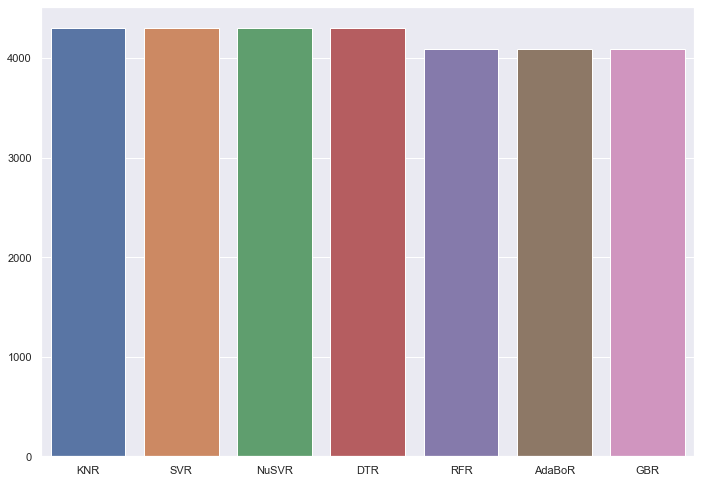

In [64]:
xx = ['KNR', 'SVR', 'NuSVR', 'DTR', 'RFR', 'AdaBoR', 'GBR']
yy = best
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=xx, y=yy)

<AxesSubplot:>

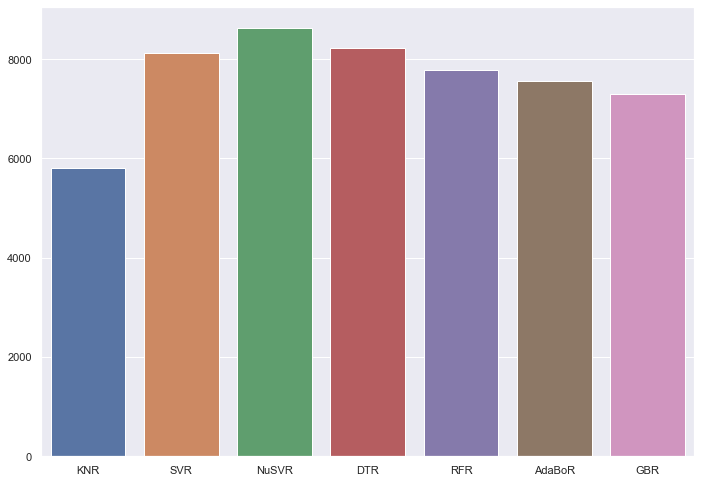

In [65]:
xx = ['KNR', 'SVR', 'NuSVR', 'DTR', 'RFR', 'AdaBoR', 'GBR']
yy = avg
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=xx, y=yy)